In [1]:
conda activate TFgpu


Note: you may need to restart the kernel to use updated packages.


![Image Description](Image/Twitter1.png)

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import FunctionTransformer
import re

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text_list, tokenizer, stopwords_list, remove_words):
    '''
    Takes in a list of strings, a tokenizer, a list of stopwords, and a list of words to remove.
    Returns a list of lowercased, tokenized, stopwords-removed, and lemmatized words.
    '''
    # lowercase
    lower = [str(text).lower() for text in text_list]

    # tokenize
    tokenized = [tokenizer.tokenize(tweet) for tweet in lower]

    # stopwords and special characters
    no_stops = []
    for item in tokenized:
        temp = []
        for token in item:
            if token not in stopwords_list and token not in remove_words:
                # Remove special characters
                token = re.sub(r'\W+', '', token)
                temp.append(token)
        no_stops.append(temp)

    # preparation for lemmatization
    tags = [pos_tag(tokens) for tokens in no_stops]

    better_tags = []
    for item in tags:
        temp1 = []
        for word in item:
            temp1.append((word[0], get_wordnet_pos(word[1])))
        better_tags.append(temp1)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    lem = []
    for item in better_tags:
        temp2 = []
        for word in item:
            temp2.append(lemmatizer.lemmatize(word[0], word[1]))
        lem.append(temp2)

    preprocessed = [' '.join(i) for i in lem]

    return preprocessed

# Read the dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# Remove tweets with unknown sentiment
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the tokenizer and stopwords list
tokenizer = TweetTokenizer()
stopwords_list = stopwords.words('english')

# Define the words to remove
remove_words = ['rt', 'mention', '2', 'iphone', 'sxswi', '2åê', '522', 522, '32', '0134' ]

# Create the pipeline for logistic regression
lr_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Create the pipeline for the dummy model
dummy_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# Define the hyperparameters to tune for logistic regression
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'classifier__C': [0.1, 1.0, 10.0]  # inverse of regularization strength
}

# Perform hyperparameter tuning using GridSearchCV for logistic regression
grid_search_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get the best hyperparameters and model from GridSearchCV for logistic regression
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

# Train the logistic regression model with the best hyperparameters
best_model_lr.fit(X_train, y_train)

# Make predictions using the logistic regression model
y_pred_lr = best_model_lr.predict(X_test)

# Calculate evaluation metrics for the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=1.0)

# Train the dummy model
dummy_pipeline.fit(X_train, y_train)

# Make predictions using the dummy model
y_pred_dummy = dummy_pipeline.predict(X_test)

# Calculate evaluation metrics for the dummy model
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
recall_dummy = recall_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)

# Print the evaluation metrics for the logistic regression model
print('Logistic Regression Model:')
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1-score: {f1_lr}')
print('')

# Print the evaluation metrics for the dummy model
print('Dummy Classifier:')
print(f'Accuracy: {accuracy_dummy}')
print(f'Precision: {precision_dummy}')
print(f'Recall: {recall_dummy}')
print(f'F1-score: {f1_dummy}')


Logistic Regression Model:
Accuracy: 0.6722595078299777
Precision: 0.6640956062012772
Recall: 0.6722595078299777
F1-score: 0.6639586436968494

Dummy Classifier:
Accuracy: 0.6124161073825504
Precision: 0.7626373811990451
Recall: 0.6124161073825504
F1-score: 0.4652068245465783


In [17]:
from collections import Counter

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Count the frequency of each word
word_counts = Counter(tokens_filtered)

# Get the top 10 most common words and their frequencies
top_words = word_counts.most_common(30)

# Extract the words
words = [word for word, _ in top_words]

# Print the top 10 words
print("Top 30 Words:")
for word in words:
    print(word)


Top 30 Words:
sxsw
link
ipad
google
apple
store
new
austin
launch
app
get
circle
social
popup
android
today
open
network
go
line
via
party
call
free
mobile
come
one
see
time
major


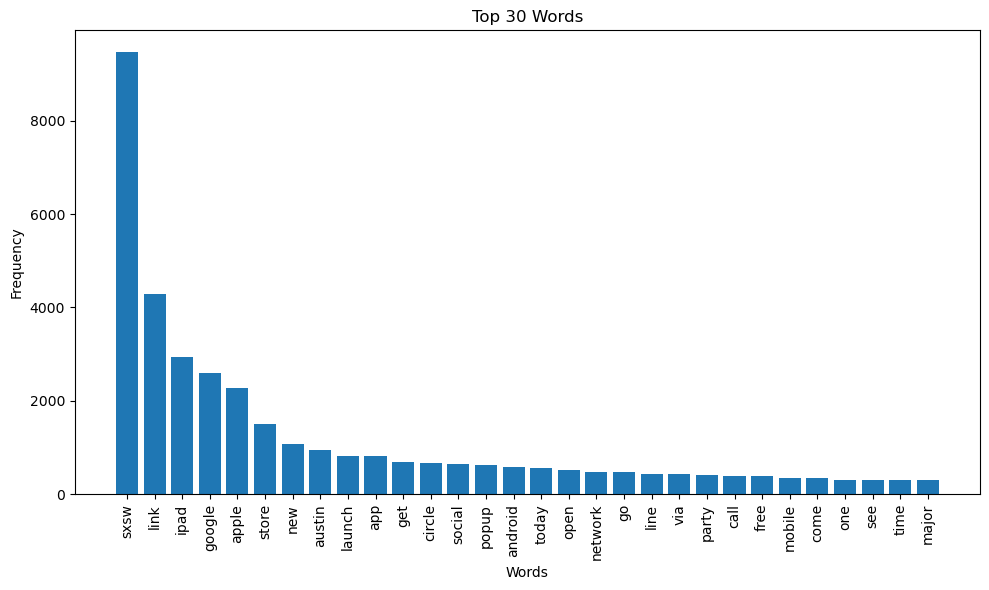

In [18]:
import matplotlib.pyplot as plt

# Top 10 words and their frequencies
top_words = word_counts.most_common(30)
words, frequencies = zip(*top_words)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


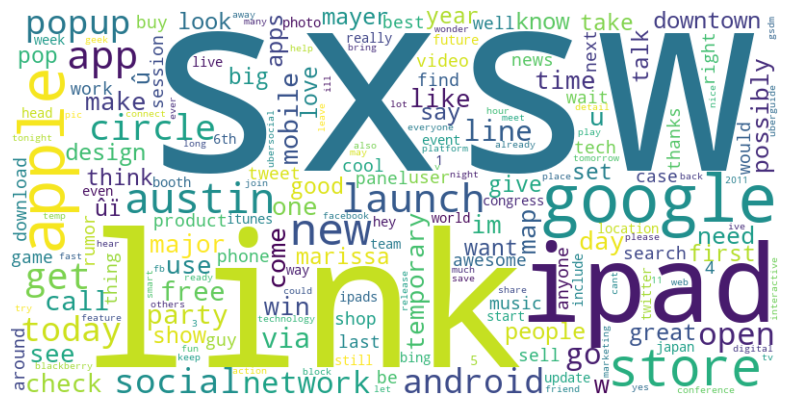

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Create a frequency dictionary of the filtered words
word_freq = {}
for word in tokens_filtered:
    word_freq[word] = word_freq.get(word, 0) + 1

# Generate the word cloud based on the word frequency
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


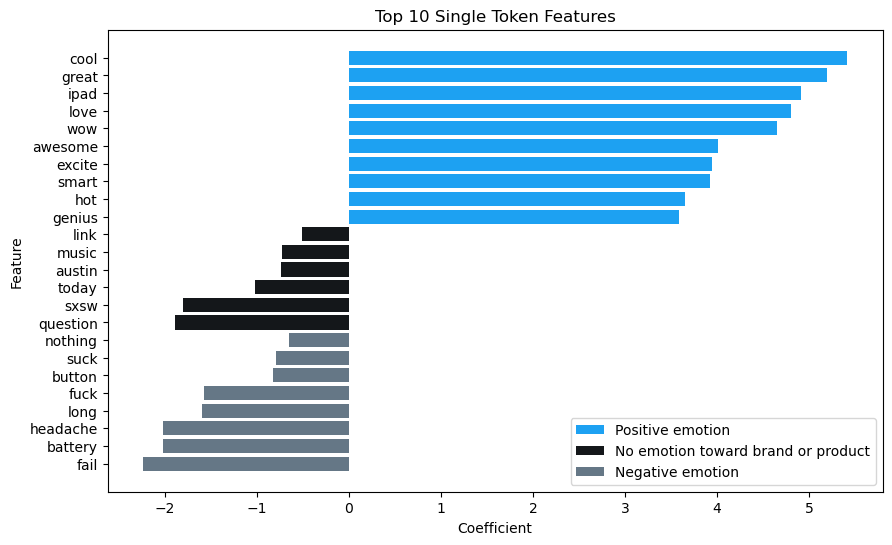

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Get the top 10 single token features for each classification from the logistic regression model
feature_names = best_model_lr.named_steps['tfidf'].vocabulary_
coefficients = best_model_lr.named_steps['classifier'].coef_

top_features_per_class = []
for i, emotion in enumerate(best_model_lr.named_steps['classifier'].classes_):
    top_coefficients = np.argsort(coefficients[i])[-10:]
    top_features = [word for word, idx in feature_names.items() if idx in top_coefficients and len(word.split()) == 1]  # Filter out two-word tokens
    top_features_per_class.append((emotion, top_features))

# Plotting the top 10 single token features for each classification
plt.figure(figsize=(10, 6))
colors = ['#657786', '#14171A', '#1DA1F2']  # Define colors for each group
for idx, (emotion, top_features) in enumerate(top_features_per_class):
    top_coefficients = np.array([coefficients[i][feature_names[word]] for word in top_features])  # Get the corresponding coefficients
    sorted_indices = np.argsort(top_coefficients)  # Sort the indices based on coefficients
    top_features = np.array(top_features)[sorted_indices]
    top_coefficients = top_coefficients[sorted_indices]
    plt.barh(top_features, top_coefficients, color=colors[idx], label=emotion)  # Assign colors and labels
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Top 10 Single Token Features')

# Adjust the legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0]  # Specify the desired order of the legend
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

plt.show()


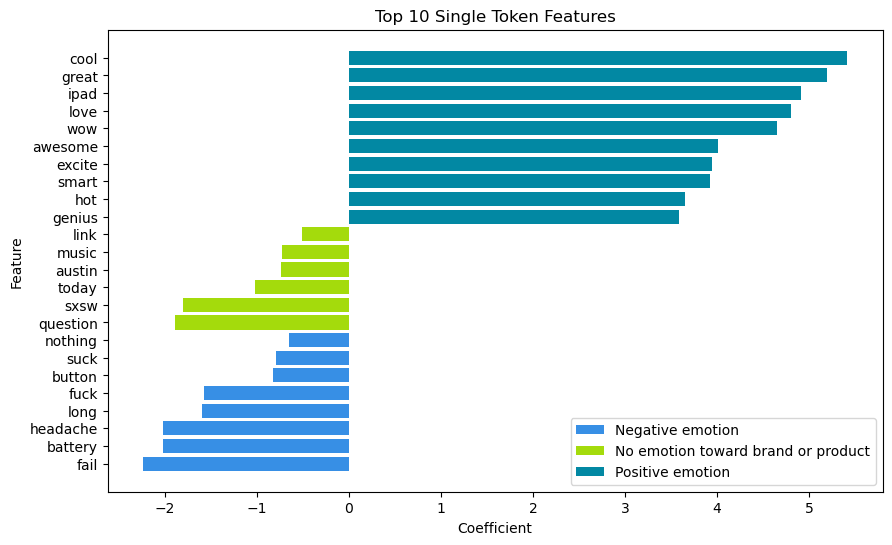

In [98]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Get the top 10 single token features for each classification from the logistic regression model
# feature_names = best_model_lr.named_steps['tfidf'].vocabulary_
# coefficients = best_model_lr.named_steps['classifier'].coef_

# top_features_per_class = []
# for i, emotion in enumerate(best_model_lr.named_steps['classifier'].classes_):
#     top_coefficients = np.argsort(coefficients[i])[-10:]
#     top_features = [word for word, idx in feature_names.items() if idx in top_coefficients and len(word.split()) == 1]  # Filter out two-word tokens
#     top_features_per_class.append((emotion, top_features))

# # Plotting the top 10 single token features for each classification
# plt.figure(figsize=(10, 6))
# colors = ['#378FE5', '#A4DB0C', '#0288A3']  # Define colors for each group
# for idx, (emotion, top_features) in enumerate(top_features_per_class):
#     top_coefficients = np.array([coefficients[i][feature_names[word]] for word in top_features])  # Get the corresponding coefficients
#     sorted_indices = np.argsort(top_coefficients)  # Sort the indices based on coefficients
#     top_features = np.array(top_features)[sorted_indices]
#     top_coefficients = top_coefficients[sorted_indices]
#     plt.barh(top_features, top_coefficients, color=colors[idx], label=emotion)  # Assign colors and labels
#     plt.xlabel('Coefficient')
#     plt.ylabel('Feature')
#     plt.title('Top 10 Single Token Features')
#     plt.legend()

# plt.show()


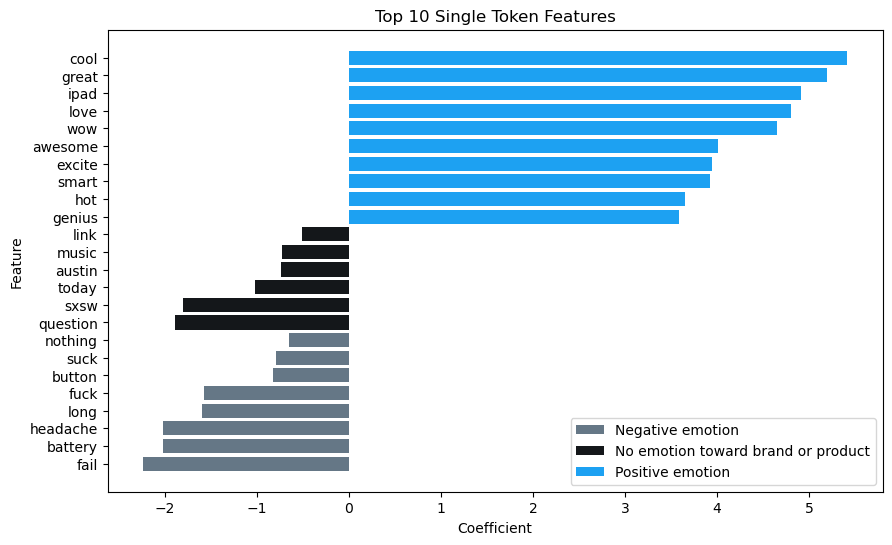

In [101]:
# [import numpy as np
# import matplotlib.pyplot as plt

# # Get the top 10 single token features for each classification from the logistic regression model
# feature_names = best_model_lr.named_steps['tfidf'].vocabulary_
# coefficients = best_model_lr.named_steps['classifier'].coef_

# top_features_per_class = []
# for i, emotion in enumerate(best_model_lr.named_steps['classifier'].classes_):
#     top_coefficients = np.argsort(coefficients[i])[-10:]
#     top_features = [word for word, idx in feature_names.items() if idx in top_coefficients and len(word.split()) == 1]  # Filter out two-word tokens
#     top_features_per_class.append((emotion, top_features))

# # Plotting the top 10 single token features for each classification
# plt.figure(figsize=(10, 6))
# colors = ['#657786', '#14171A', '#1DA1F2']  # Define colors for each group
# for idx, (emotion, top_features) in enumerate(top_features_per_class):
#     top_coefficients = np.array([coefficients[i][feature_names[word]] for word in top_features])  # Get the corresponding coefficients
#     sorted_indices = np.argsort(top_coefficients)  # Sort the indices based on coefficients
#     top_features = np.array(top_features)[sorted_indices]
#     top_coefficients = top_coefficients[sorted_indices]
#     plt.barh(top_features, top_coefficients, color=colors[idx], label=emotion)  # Assign colors and labels
#     plt.xlabel('Coefficient')
#     plt.ylabel('Feature')
#     plt.title('Top 10 Single Token Features')
#     plt.legend()

# plt.show()


In [50]:
# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Print the class labels
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")


Class 0: Negative emotion
Class 1: No emotion toward brand or product
Class 2: Positive emotion


In [51]:
import numpy as np
import pandas as pd

# Get the top features for the first classification from the logistic regression model
class_index = 0  # Index of the first classification (0-based index)
emotion = best_model_lr.named_steps['classifier'].classes_[class_index]
feature_names = list(best_model_lr.named_steps['tfidf'].vocabulary_.keys())
coefficients = best_model_lr.named_steps['classifier'].coef_[class_index]

# Filter out the two-word tokens
top_features = [feature for feature in feature_names if len(feature.split()) == 1]

# Get the corresponding coefficients for the filtered features
top_coefficients = [coefficients[feature_names.index(feature)] for feature in top_features]

# Sort the features and coefficients in descending order based on coefficients
sorted_indices = np.argsort(top_coefficients)[::-1]
top_features = np.array(top_features)[sorted_indices]
top_coefficients = np.array(top_coefficients)[sorted_indices]

# Create a dataframe with the top features and coefficients
Negative_emotion = pd.DataFrame({'Feature': top_features, 'Value Impact': top_coefficients})

Negative_emotion = Negative_emotion.head(20) 

Negative_emotion

,Feature,Value Impact
0,androids,4.196545
1,bavcid,3.176117
2,fandango,2.549207
3,virgin,2.332283
4,opinion,2.247892
5,confusion,2.181954
6,people,2.130228
7,inertia,2.101693
8,set,2.084414
9,cvdc,1.878289


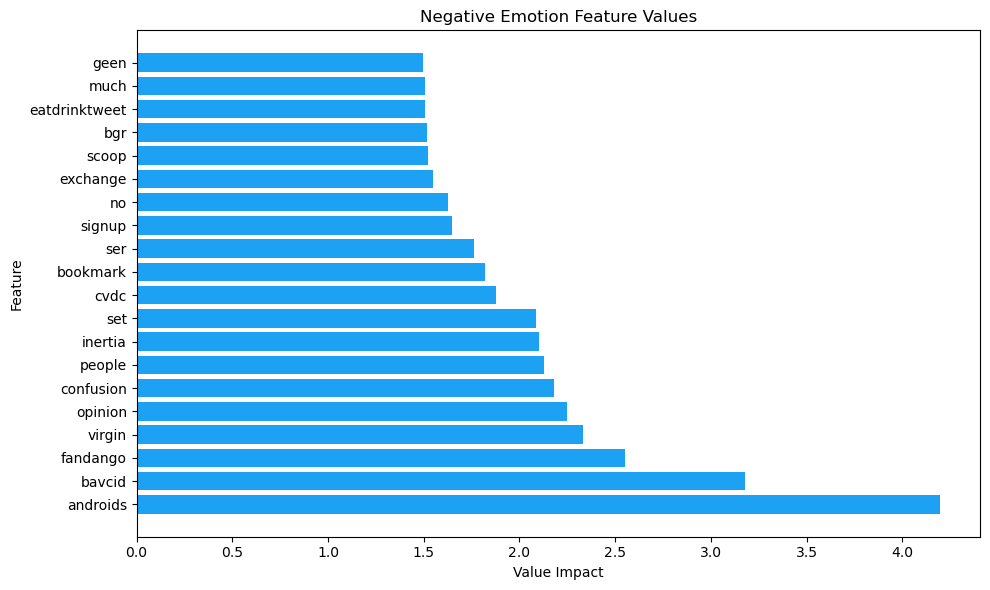

In [102]:
# Extract the feature names and values
features = Negative_emotion['Feature']
values = Negative_emotion['Value Impact']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.barh(features, values, color='#1DA1F2')
plt.xlabel('Value Impact')
plt.ylabel('Feature')
plt.title('Negative Emotion Feature Values')
plt.tight_layout()

plt.show()

In [23]:
import numpy as np
import pandas as pd

# Get the top features for the first classification from the logistic regression model
class_index = 1  # Index of the first classification (0-based index)
emotion = best_model_lr.named_steps['classifier'].classes_[class_index]
feature_names = list(best_model_lr.named_steps['tfidf'].vocabulary_.keys())
coefficients = best_model_lr.named_steps['classifier'].coef_[class_index]

# Filter out the two-word tokens
top_features = [feature for feature in feature_names if len(feature.split()) == 1]

# Get the corresponding coefficients for the filtered features
top_coefficients = [coefficients[feature_names.index(feature)] for feature in top_features]

# Sort the features and coefficients in descending order based on coefficients
sorted_indices = np.argsort(top_coefficients)[::-1]
top_features = np.array(top_features)[sorted_indices]
top_coefficients = np.array(top_coefficients)[sorted_indices]

# Create a dataframe with the top features and coefficients
No_emotion = pd.DataFrame({'Feature': top_features, 'Value Impact': top_coefficients})

No_emotion = No_emotion.head(20) 

No_emotion

,Feature,Value Impact
0,landlord,5.790735
1,voxpop,2.024796
2,8th,1.953174
3,5pm,1.950636
4,ill,1.908609
5,atlantic,1.864831
6,tx,1.644736
7,snoop,1.626266
8,tease,1.617262
9,max,1.607159


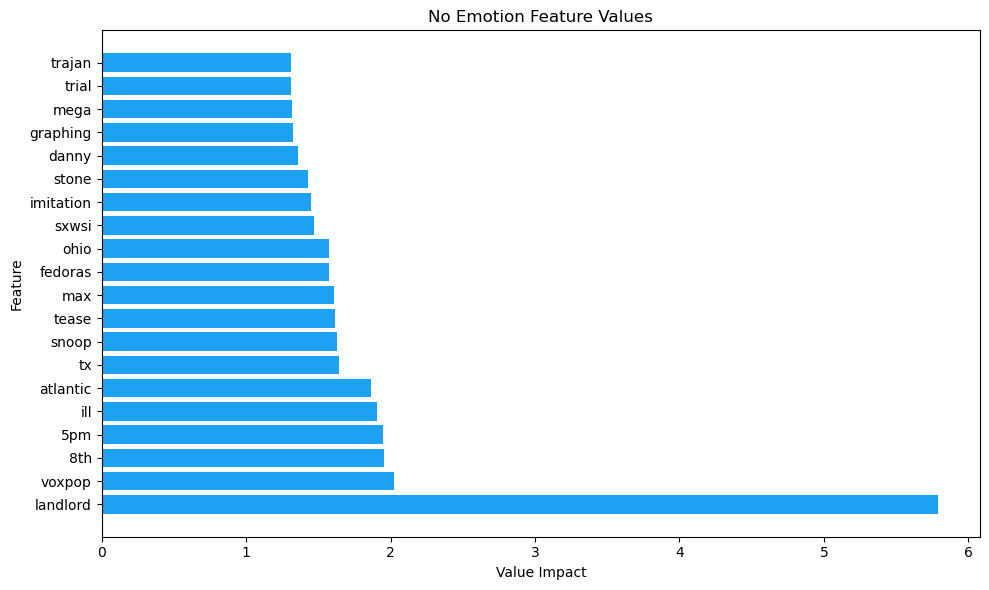

In [103]:
# Extract the feature names and values
features = No_emotion['Feature']
values = No_emotion['Value Impact']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.barh(features, values, color='#1DA1F2')
plt.xlabel('Value Impact')
plt.ylabel('Feature')
plt.title('No Emotion Feature Values')
plt.tight_layout()

plt.show()

In [25]:
import numpy as np
import pandas as pd

# Get the top features for the first classification from the logistic regression model
class_index = 2  # Index of the first classification (0-based index)
emotion = best_model_lr.named_steps['classifier'].classes_[class_index]
feature_names = list(best_model_lr.named_steps['tfidf'].vocabulary_.keys())
coefficients = best_model_lr.named_steps['classifier'].coef_[class_index]

# Filter out the two-word tokens
top_features = [feature for feature in feature_names if len(feature.split()) == 1]

# Get the corresponding coefficients for the filtered features
top_coefficients = [coefficients[feature_names.index(feature)] for feature in top_features]

# Sort the features and coefficients in descending order based on coefficients
sorted_indices = np.argsort(top_coefficients)[::-1]
top_features = np.array(top_features)[sorted_indices]
top_coefficients = np.array(top_coefficients)[sorted_indices]

# Create a dataframe with the top features and coefficients
Positive_Emotion = pd.DataFrame({'Feature': top_features, 'Value Impact': top_coefficients})

Positive_Emotion = Positive_Emotion.head(20) 

Positive_Emotion

,Feature,Value Impact
0,preso,5.412129
1,flav,3.582091
2,beef,2.660835
3,4sqchat,2.561833
4,dgtltribe,2.407969
5,attendance,2.291153
6,rave,2.260875
7,chrismessina,2.085480
8,netflix,1.973033
9,niceness,1.772699


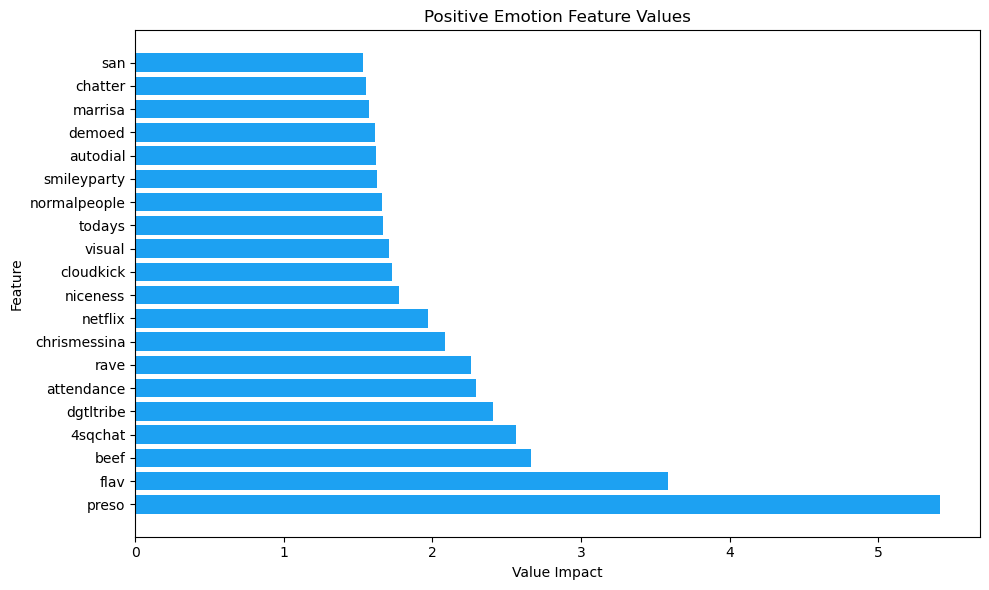

In [106]:
# Extract the feature names and values
features = Positive_Emotion['Feature']
values = Positive_Emotion['Value Impact']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.barh(features, values, color='#1DA1F2')
plt.xlabel('Value Impact')
plt.ylabel('Feature')
plt.title('Positive Emotion Feature Values')
plt.tight_layout()

plt.show()

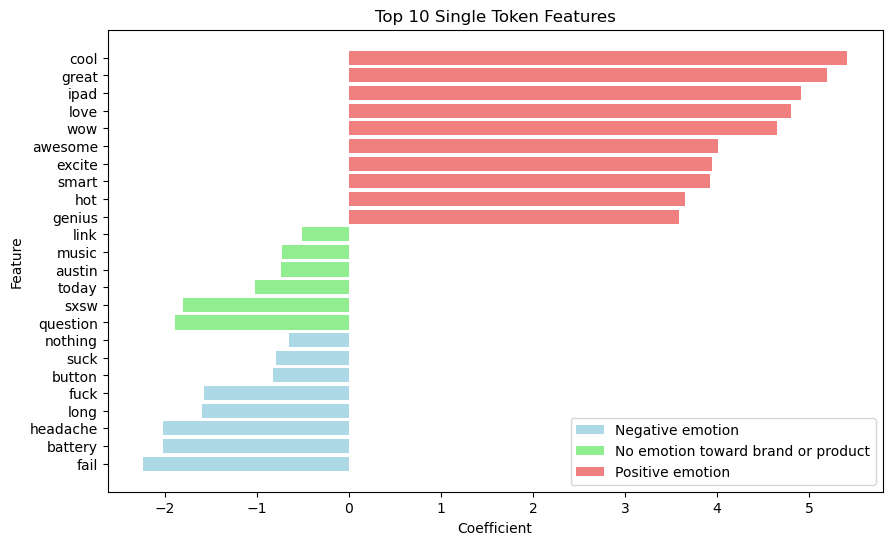

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Get the top 10 single token features for each classification from the logistic regression model
feature_names = best_model_lr.named_steps['tfidf'].vocabulary_
coefficients = best_model_lr.named_steps['classifier'].coef_

top_features_per_class = []
for i, emotion in enumerate(best_model_lr.named_steps['classifier'].classes_):
    top_coefficients = np.argsort(coefficients[i])[-10:]
    top_features = [word for word, idx in feature_names.items() if idx in top_coefficients and len(word.split()) == 1]  # Filter out two-word tokens
    top_features_per_class.append((emotion, top_features))

# Plotting the top 10 single token features for each classification
plt.figure(figsize=(10, 6))
colors = ['lightblue', 'lightgreen', 'lightcoral']  # Define colors for each group
for idx, (emotion, top_features) in enumerate(top_features_per_class):
    top_coefficients = np.array([coefficients[i][feature_names[word]] for word in top_features])  # Get the corresponding coefficients
    sorted_indices = np.argsort(top_coefficients)  # Sort the indices based on coefficients
    top_features = np.array(top_features)[sorted_indices]
    top_coefficients = top_coefficients[sorted_indices]
    plt.barh(top_features, top_coefficients, color=colors[idx], label=emotion)  # Assign colors and labels
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Top 10 Single Token Features')
    plt.legend()

plt.show()


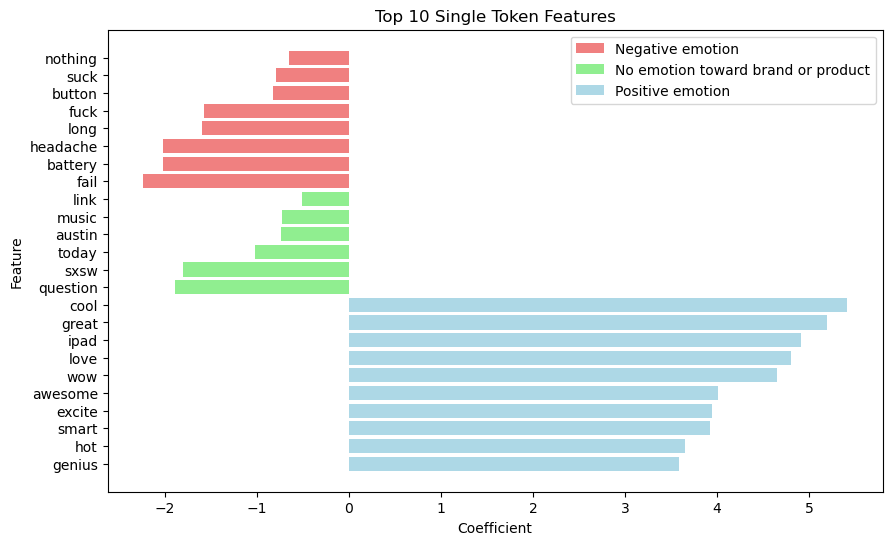

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Get the top 10 single token features for each classification from the logistic regression model
feature_names = best_model_lr.named_steps['tfidf'].vocabulary_
coefficients = best_model_lr.named_steps['classifier'].coef_

top_features_per_class = []
for i, emotion in enumerate(best_model_lr.named_steps['classifier'].classes_):
    top_coefficients = np.argsort(coefficients[i])[-10:]
    top_features = [word for word, idx in feature_names.items() if idx in top_coefficients and len(word.split()) == 1]  # Filter out two-word tokens
    top_features_per_class.append((emotion, top_features))

# Reverse the order of elements in top_features_per_class
top_features_per_class.reverse()

# Plotting the top 10 single token features for each classification
plt.figure(figsize=(10, 6))
colors = ['lightblue', 'lightgreen', 'lightcoral']  # Define colors for each group
for idx, (emotion, top_features) in enumerate(top_features_per_class):
    top_coefficients = np.array([coefficients[i][feature_names[word]] for word in top_features])  # Get the corresponding coefficients
    sorted_indices = np.argsort(top_coefficients)  # Sort the indices based on coefficients
    top_features = np.array(top_features)[sorted_indices]
    top_coefficients = top_coefficients[sorted_indices]
    plt.barh(top_features, top_coefficients, color=colors[idx], label=emotion)  # Assign colors and labels
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Top 10 Single Token Features')

# Reverse the order of the legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.show()


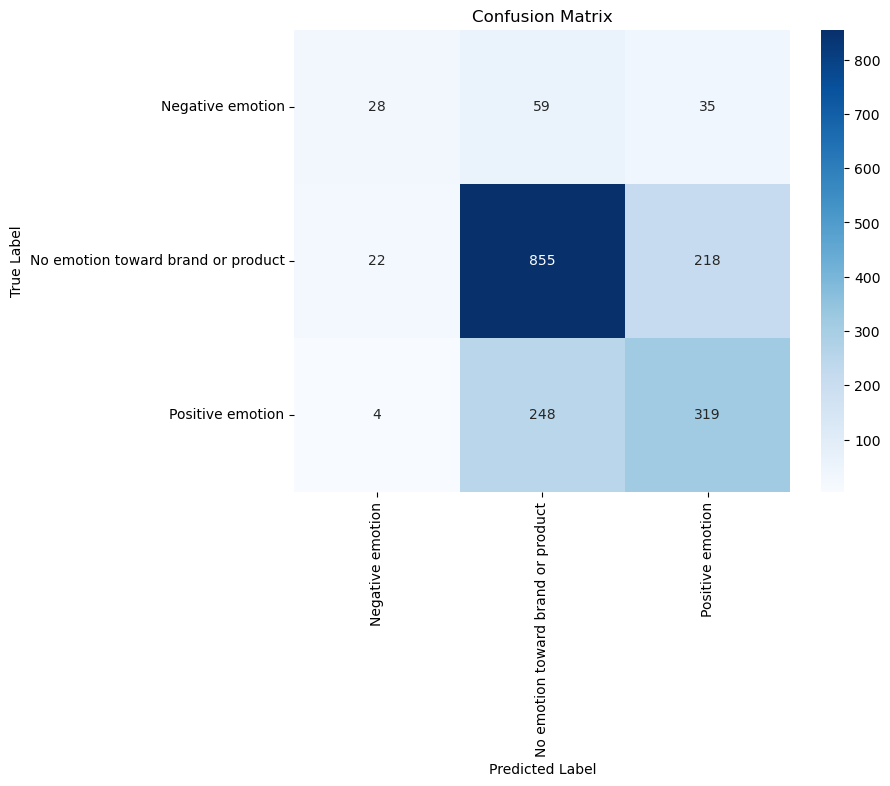

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predicted labels for the test set
y_pred = best_model_lr.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class labels
class_labels = best_model_lr.named_steps['classifier'].classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


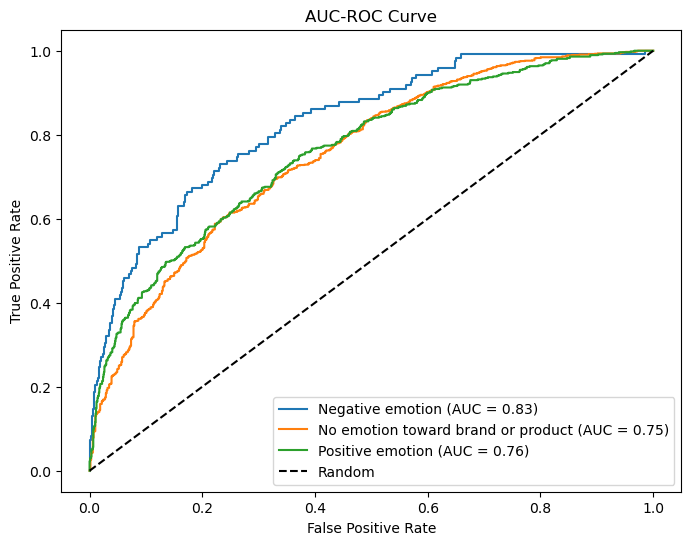

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_probs = best_model_lr.predict_proba(X_test)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(best_model_lr.named_steps['classifier'].classes_):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test, y_probs[:, i], pos_label=class_label)
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot the AUC-ROC curve for each class
plt.figure(figsize=(8, 6))
for class_label in best_model_lr.named_steps['classifier'].classes_:
    plt.plot(fpr[class_label], tpr[class_label], label=f'{class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()


![Image Description](Image/Twitter.png)

# If my team has gotten this far in this notebook..... Just know I am probably really tired lol 